## Setup ##

In [13]:
"""Visualize embeddings produced"""
import numpy as np
import tensorflow as tf 
import h5py
import matplotlib.pyplot as plt
import os

from skimage import measure

import utils

%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = ''

ROOT = '/usr/people/kluther/Projects/metric_segmentation/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%javascript
require(
        ["notebook/js/outputarea"],
        function (oa) {
            oa.OutputArea.auto_scroll_threshold = -1;
            console.log("Setting auto_scroll_threshold to -1");
        });

<IPython.core.display.Javascript object>

## Load model/data ##

In [15]:
"""Load data"""
#em_imgs  = h5py.File(os.path.join(ROOT, 'data', 'human_labels_boundary.h5'), 'r')['main']
em_imgs  = h5py.File(os.path.join(ROOT, 'data', 'voronoi_boundary.h5'), 'r')['main']
#em_imgs  = h5py.File(os.path.join(ROOT, 'data', 'image.h5'), 'r')['main']
#seg_imgs = h5py.File(os.path.join(ROOT, 'data', 'human_labels_split.h5'), 'r')['main']
seg_imgs = h5py.File(os.path.join(ROOT, 'data', 'voronoi_segmentation.h5'), 'r')['main']

"""
em_imgs_train = em_imgs[:192]
seg_imgs_train = seg_imgs[:192]
em_imgs_dev = em_imgs[192:]
seg_imgs_dev = seg_imgs[192:]
"""
em_imgs_train = em_imgs[:16]
seg_imgs_train = seg_imgs[:16]
em_imgs_dev = em_imgs[16:]
seg_imgs_dev = seg_imgs[16:]


In [24]:
"""Load model"""
N = 0 #Iteration number
#EXP_NAME = 'j_loss_boundary_map_input_affinity_1_mask_on'
EXP_NAME = 'voronoi_object_mask_alpha_1_beta_0.1_embed_32_K_50_lr_0.0001'
#EXP_NAME = 'j_loss_embed_dim_32_affinity_128'
#EXP_NAME = 'boundary_mask_off_augment_on'
MODEL_NAME = os.path.join(ROOT, 'experiments', EXP_NAME, 'models', 'model{}.ckpt'.format(N))

tf.reset_default_graph()
sess = tf.Session()
inputs, outputs = utils.load_model(MODEL_NAME, sess)

INFO:tensorflow:Restoring parameters from /usr/people/kluther/Projects/metric_segmentation/experiments/voronoi_object_mask_alpha_1_beta_0.1_embed_32_K_50_lr_0.0001/models/model0.ckpt


In [25]:
"""Generate vector labels for a particular input image"""
em_train = em_imgs_train[-1, 0:572, 0:572]
seg_train = seg_imgs_train[-1, 0:572, 0:572]
vec_train = utils.generate_vector_labels(inputs, outputs, em_train, sess)

em_dev = em_imgs_dev[-1, 0:572, 0:572]
seg_dev = seg_imgs_dev[-1, 0:572, 0:572]
vec_dev = utils.generate_vector_labels(inputs, outputs, em_dev, sess)

# Crop input images to match output sizes 
l = (572-388)//2
u = l+388
em_train = em_train[l:u, l:u]
em_dev = em_dev[l:u, l:u]
seg_train = seg_train[l:u,l:u]
seg_dev = seg_dev[l:u,l:u]

In [26]:
"""Create images to visualize vector labels""" 
# RGB Projection
rgb_train = vec_train[:,:,0:3]
rgb_train = rgb_train/np.max(rgb_train)#*255
rgb_dev = vec_dev[:,:,0:3]
rgb_dev = rgb_dev/np.max(rgb_dev)

# Boundary map
def gradient_norm(vec_field):
  """Returns norm of gradient at each point in vec_field"""
  gx = vec_field[1:,:-1]-vec_field[:-1,:-1]
  gy = vec_field[:-1,1:]-vec_field[:-1,:-1]

  return np.sqrt(np.linalg.norm(gx,axis=-1)**2+np.linalg.norm(gy,axis=-1)**2)

vec_grad_train = gradient_norm(vec_train)
vec_grad_dev = gradient_norm(vec_dev)

# Fill in boundary map
thresh = 0.4
labels_train = labels = measure.label(vec_grad_train>thresh, background=1)
labels_dev = measure.label(vec_grad_dev>thresh, background=1)


In [16]:
np.max(rgb_train)

1.3155721

## Single Model: Display Images ## 

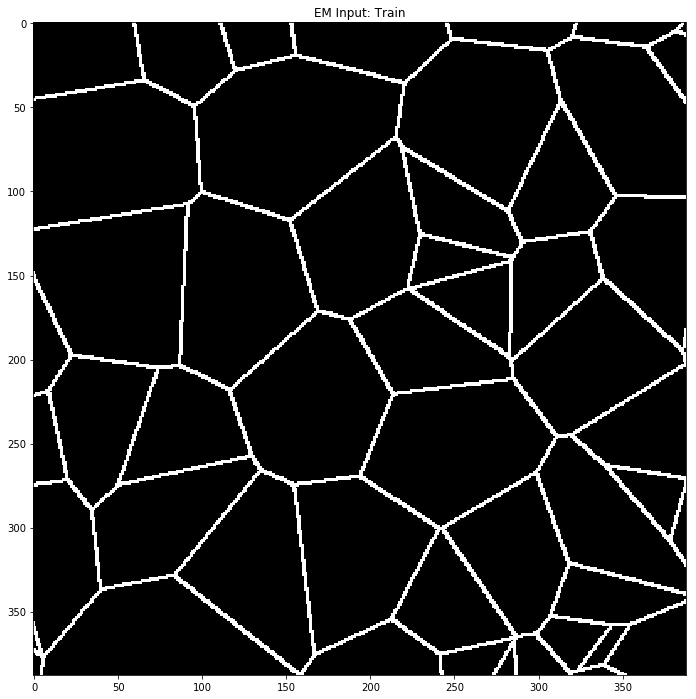

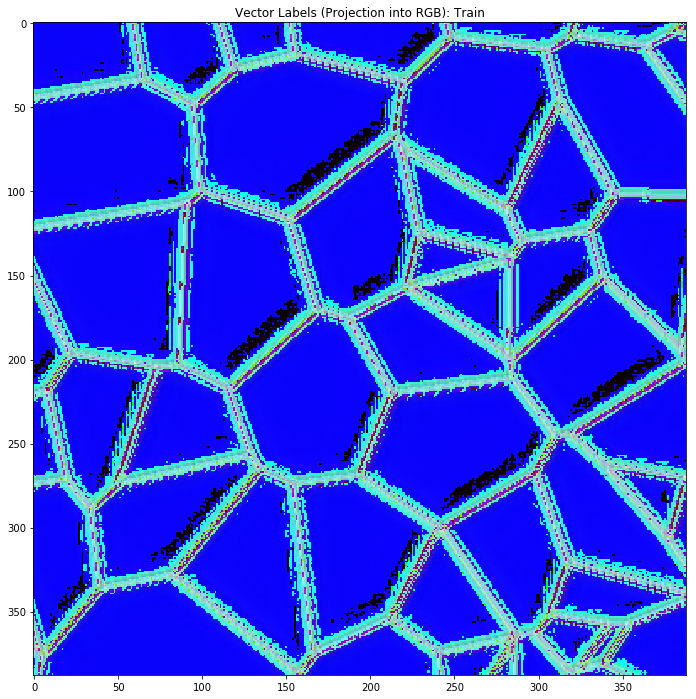

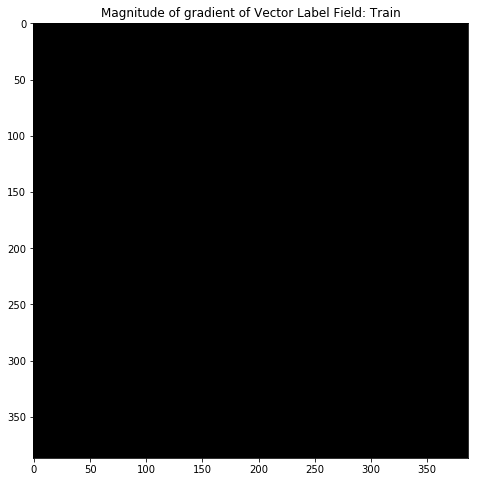

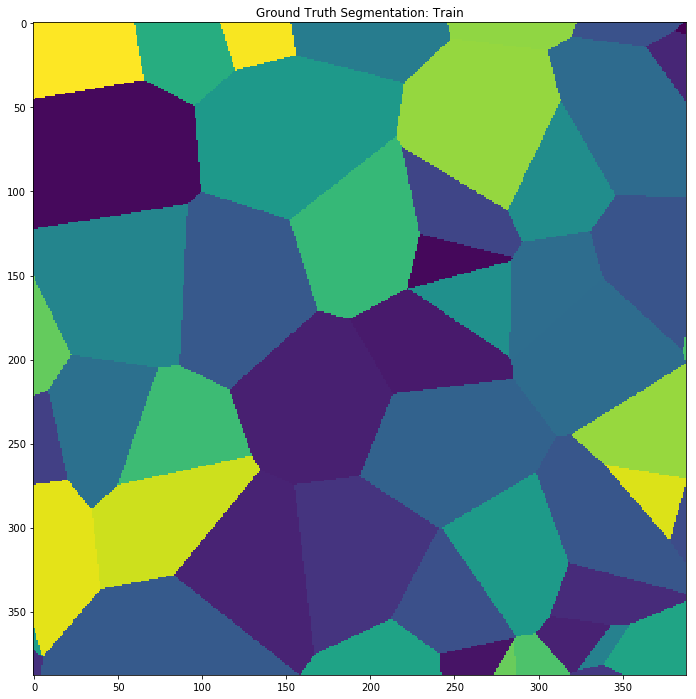

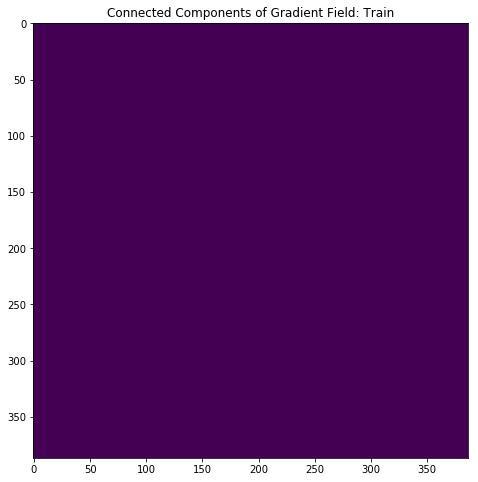

In [27]:
"""Display images: Train"""
plt.figure(figsize=(12,12))
plt.title('EM Input: Train')
plt.imshow(em_train, cmap='gray')
plt.show()

plt.figure(figsize=(12,12))
plt.title('Vector Labels (Projection into RGB): Train')
plt.imshow(rgb_train, cmap='gray')
plt.show()

plt.figure(figsize=(8,8))
plt.title('Magnitude of gradient of Vector Label Field: Train')
plt.imshow(vec_grad_train>thresh, cmap='gray')
plt.show()

plt.figure(figsize=(12,12))
plt.title('Ground Truth Segmentation: Train')
plt.imshow(seg_train)
plt.show()

plt.figure(figsize=(8,8))
plt.title('Connected Components of Gradient Field: Train')
plt.imshow(labels_train)
plt.show()

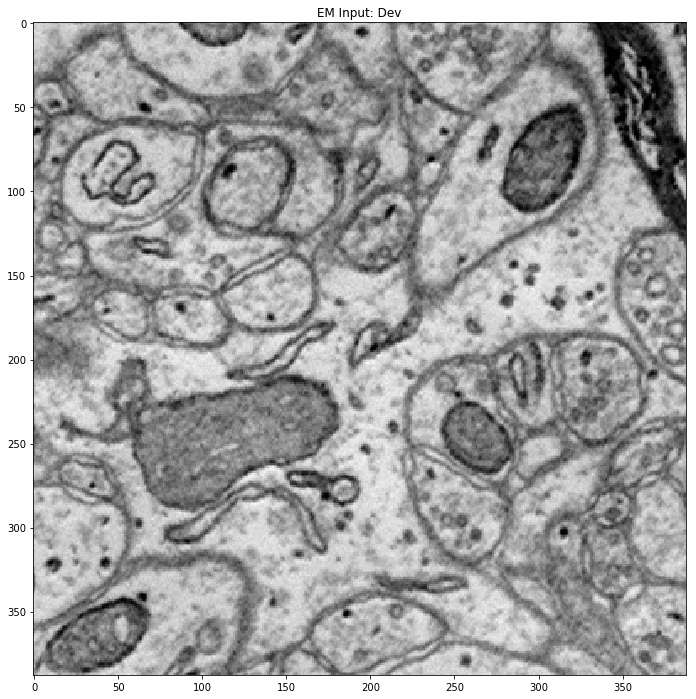

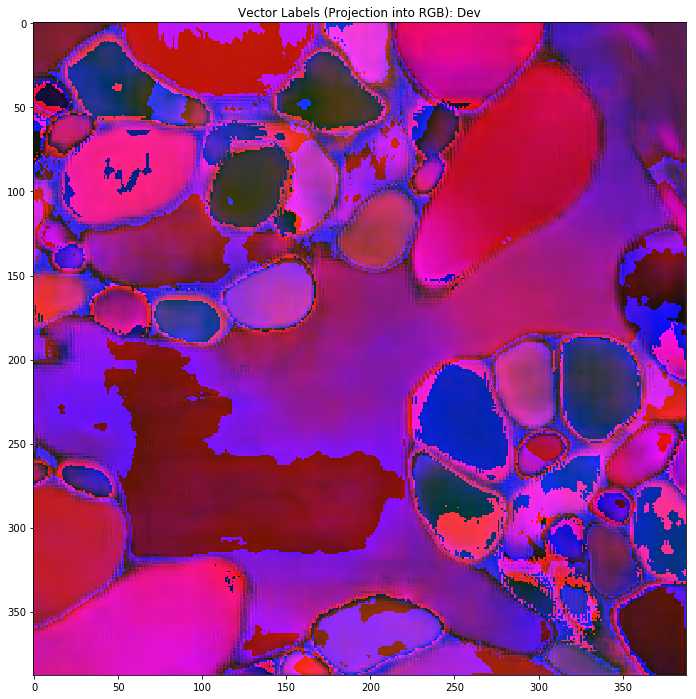

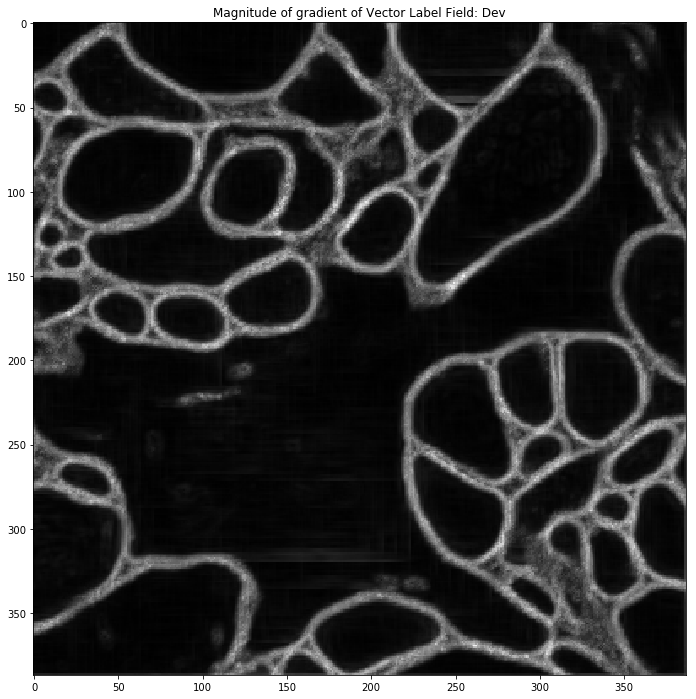

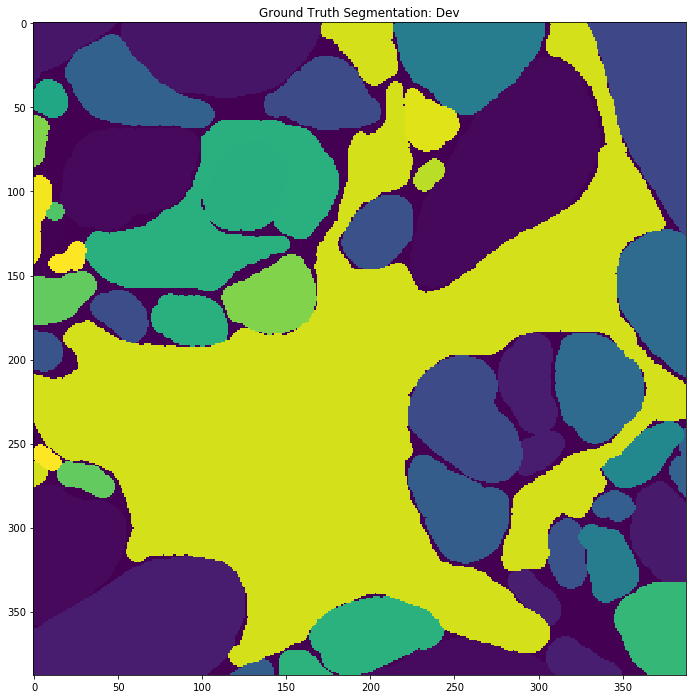

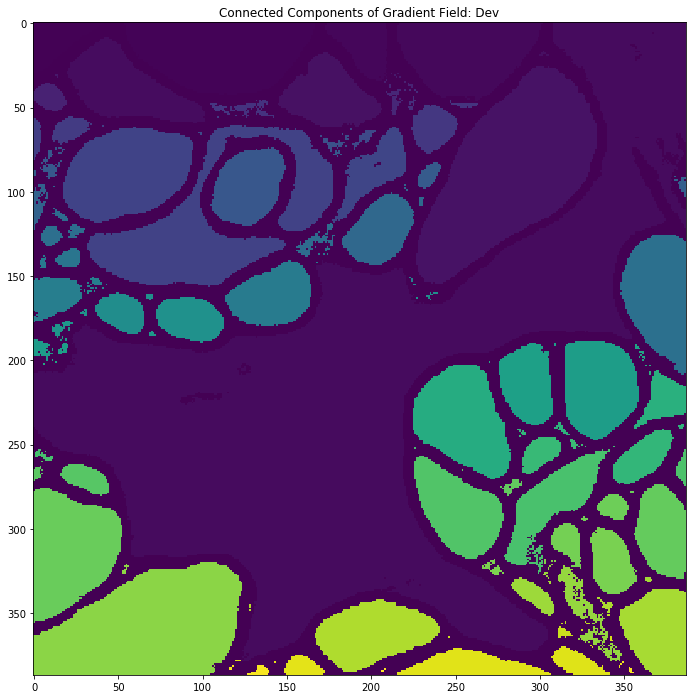

In [12]:
"""Display images: Dev"""
plt.figure(figsize=(12,12))
plt.title('EM Input: Dev')
plt.imshow(em_dev, cmap='gray')
plt.show()

plt.figure(figsize=(12,12))
plt.title('Vector Labels (Projection into RGB): Dev')
plt.imshow(rgb_dev, cmap='gray')
plt.show()

plt.figure(figsize=(12,12))
plt.title('Magnitude of gradient of Vector Label Field: Dev')
plt.imshow(vec_grad_dev, cmap='gray')
plt.show()

plt.figure(figsize=(12,12))
plt.title('Ground Truth Segmentation: Dev')
plt.imshow(seg_dev)
plt.show()

plt.figure(figsize=(12,12))
plt.title('Connected Components of Gradient Field: Dev')
plt.imshow(labels_dev)
plt.show()

## Compare Models ## 

In [23]:
"""Load models and create vector images"""
def generate_vector_labels(model_name, input_images):
    tf.reset_default_graph()
    sess = tf.Session()
    inputs, outputs = utils.load_model(model_name, sess)
    vectors = utils.generate_vector_labels(inputs, outputs, input_images, sess)
    
    return vectors 

# Choose image 
em_train = em_imgs_train[0,0:572,0:572]

# Model 1
N = 20000
EXP_NAME_1 = 'j_loss_boundary_mask_off_split_objects'
MODEL_NAME = os.path.join(ROOT, 'experiments', EXP_NAME_1, 'models', 'model{}.ckpt'.format(N))

vecs_1 = generate_vector_labels(MODEL_NAME, em_train)
rgb_1 = vecs_1[:,:,0:3]

# Model 2
#N = 40000
EXP_NAME_2 = 'j_loss_boundary_mask_on_split_objects'
MODEL_NAME = os.path.join(ROOT, 'experiments', EXP_NAME_2, 'models', 'model{}.ckpt'.format(N))

vecs_2 = generate_vector_labels(MODEL_NAME, em_train)
rgb_2 = vecs_2[:,:,0:3]

# Model 3
#N = 40000
EXP_NAME_3 = 'j_loss_boundary_mask_off_split_objects_affinity_32'
MODEL_NAME = os.path.join(ROOT, 'experiments', EXP_NAME_3, 'models', 'model{}.ckpt'.format(N))

vecs_3 = generate_vector_labels(MODEL_NAME, em_train)
rgb_3 = vecs_3[:,:,0:3]

# Model 4
#N = 40000
EXP_NAME_4 = 'j_loss_boundary_mask_on_split_objects_affinity_32'
MODEL_NAME = os.path.join(ROOT, 'experiments', EXP_NAME_4, 'models', 'model{}.ckpt'.format(N))

vecs_4 = generate_vector_labels(MODEL_NAME, em_train)
rgb_4 = vecs_4[:,:,0:3]

# Crop input images to match output sizes 
l = (572-388)//2
u = l+388
em_train = em_train[l:u, l:u]
seg_train = seg_train[l:u,l:u]


INFO:tensorflow:Restoring parameters from /usr/people/kluther/Projects/metric_segmentation/experiments/j_loss_boundary_mask_off_split_objects/models/model20000.ckpt
INFO:tensorflow:Restoring parameters from /usr/people/kluther/Projects/metric_segmentation/experiments/j_loss_boundary_mask_on_split_objects/models/model20000.ckpt
INFO:tensorflow:Restoring parameters from /usr/people/kluther/Projects/metric_segmentation/experiments/j_loss_boundary_mask_off_split_objects_affinity_32/models/model20000.ckpt
INFO:tensorflow:Restoring parameters from /usr/people/kluther/Projects/metric_segmentation/experiments/j_loss_boundary_mask_on_split_objects_affinity_32/models/model20000.ckpt


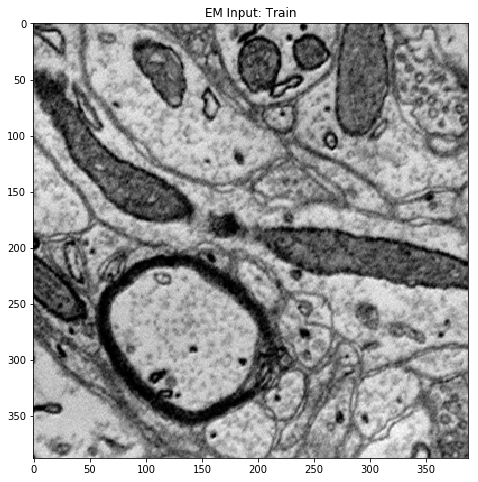

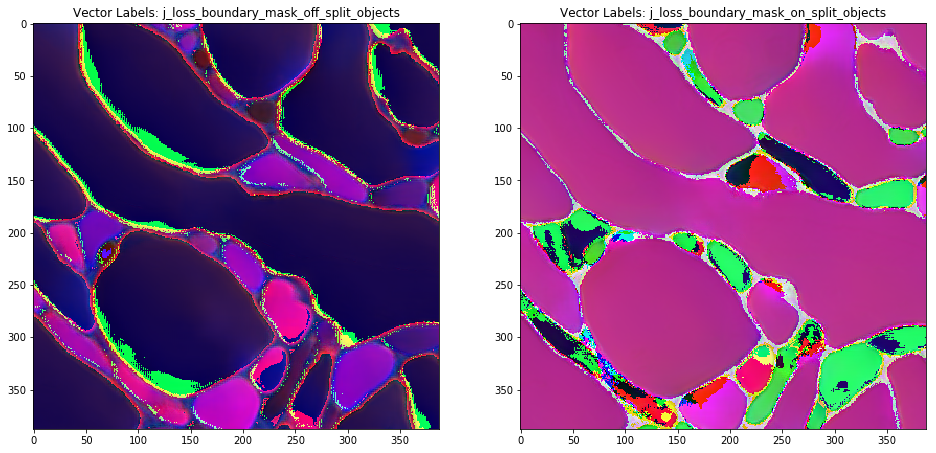

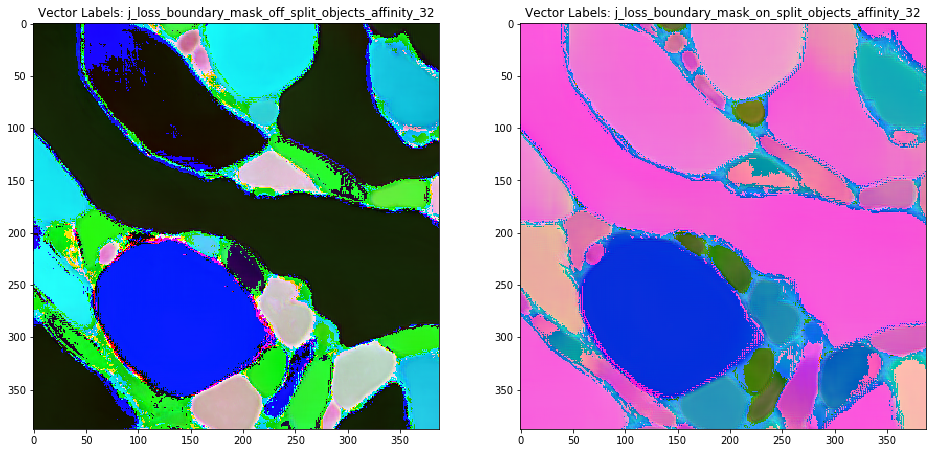

In [24]:
"""Display images"""
plt.figure(figsize=(8,8))
plt.title('EM Input: Train')
plt.imshow(em_train, cmap='gray')
plt.show()

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Vector Labels: {}'.format(EXP_NAME_1))
plt.imshow(rgb_1) 
plt.subplot(122)
plt.title('Vector Labels: {}'.format(EXP_NAME_2))
plt.imshow(rgb_2); plt.show()

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Vector Labels: {}'.format(EXP_NAME_3))
plt.imshow(rgb_3) 
plt.subplot(122)
plt.title('Vector Labels: {}'.format(EXP_NAME_4))
plt.imshow(rgb_4); plt.show()

In [38]:
seg_imgs = h5py.File(os.path.join(ROOT, 'data', 'human_labels_boundary.h5'), 'r')['main']

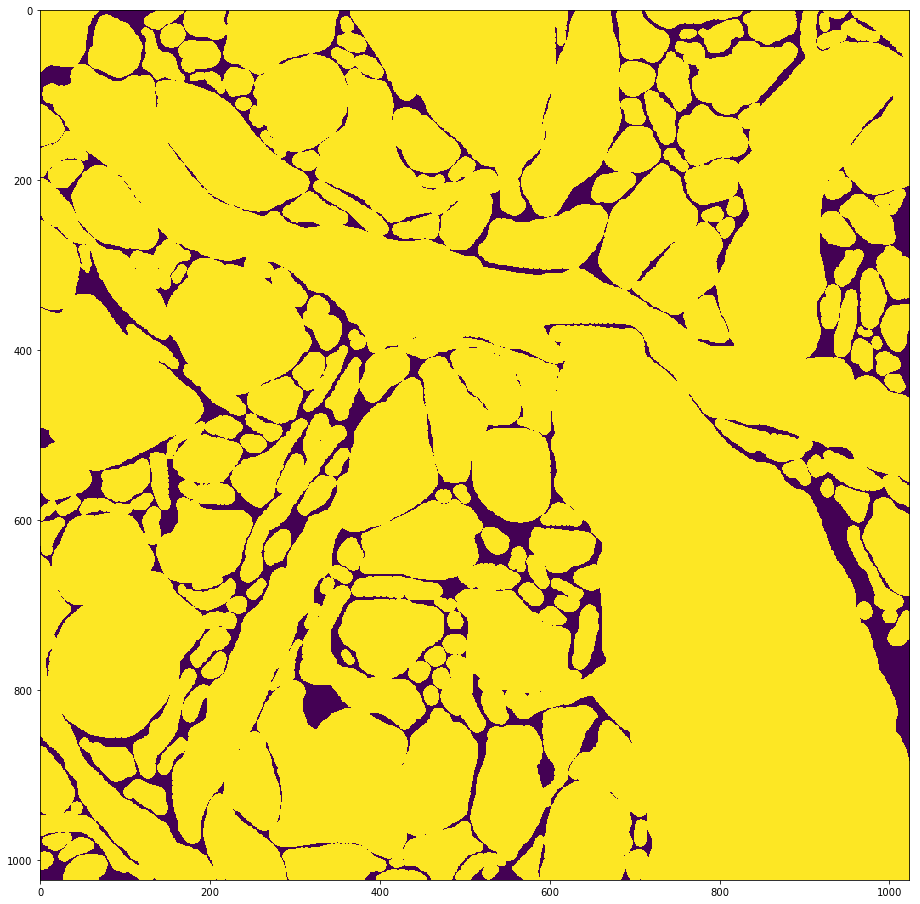

In [42]:
plt.figure(figsize=(16,16))
plt.imshow(seg_imgs[0]); plt.show()

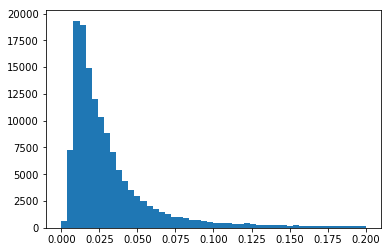

In [20]:
plt.hist(vec_grad_train.flatten(), range=(0,0.2), bins=50); plt.show()

In [93]:
def affinity(x,y):
    return np.exp(-0.5*np.linalg.norm(x-y)**2)

In [101]:
am = np.zeros((388,388))
for i in range(388):
    for j in range(388):
        am[i,j] = affinity(vec_dev[175,150], vec_dev[i,j])

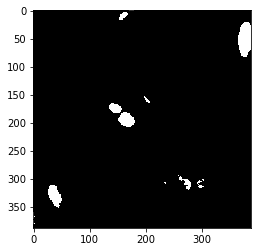

In [102]:
plt.imshow(am>0.6,cmap='gray');plt.show()

In [16]:
import sys; sys.path.append('/usr/people/kluther/Projects/metric_segmentation/src/')

In [17]:
from object_mask_loss_1 import provider

In [18]:
P = provider.EMDataGenerator('/usr/people/kluther/Projects/metric_segmentation/data/', 'train', 10)

In [19]:
nb = P.next_batch(1)

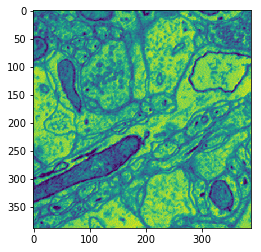

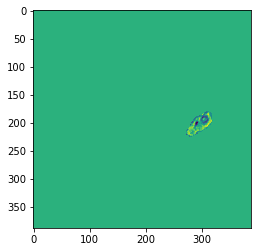

In [23]:
plt.imshow(nb[0][0,92:572-92,92:572-92,0]);plt.show()
plt.imshow(nb[1][0][0,:,:,0]*nb[0][0,92:572-92,92:572-92,0]);plt.show()

In [24]:
nb[2]

[array([202, 296]),
 array([1, 7]),
 array([190, 189]),
 array([296, 166]),
 array([56, 80]),
 array([202, 210]),
 array([200, 191]),
 array([ 4, 59]),
 array([335, 239]),
 array([200, 191])]

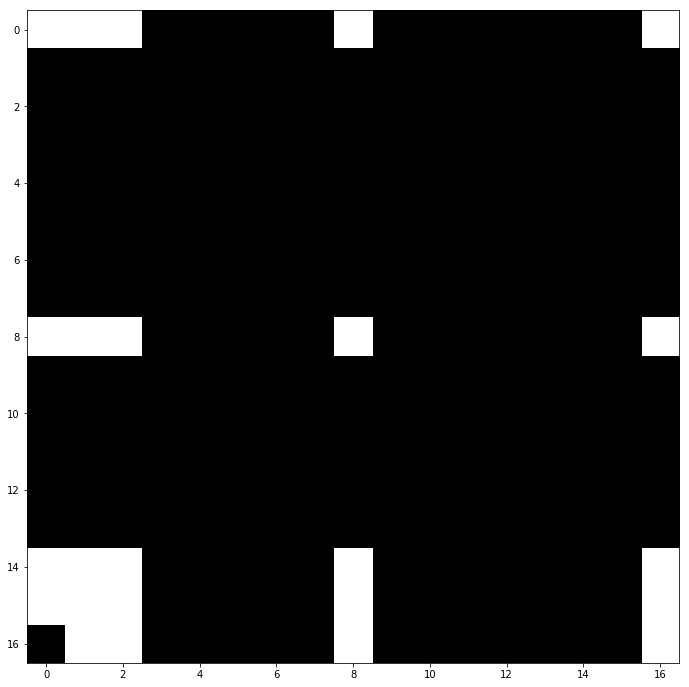

In [188]:
mask = np.zeros((17,17))
pix = (0,1,2,8,16)#32,64)
offsets = []
for i in pix:
    for j in pix:
        if (i,j) != (0,0):
             mask[i,j] = 1
mask = np.flip(mask, axis=0)
plt.figure(figsize=(12,12))
plt.imshow(mask, cmap='gray')
plt.show()